In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
import keras

In [2]:
train_raw = pd.read_csv('./train.csv')
test_raw = pd.read_csv('./test.csv')

In [3]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


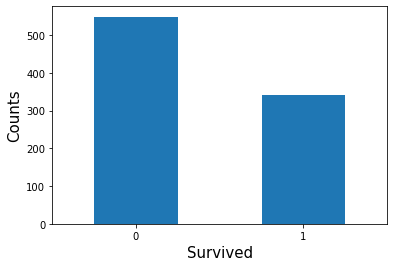

In [4]:
#sns.countplot(train_raw['Survived'])
ax = train_raw['Survived'].value_counts().plot(kind='bar',
                                         rot=0)
ax.set_xlabel('Survived', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
plt.show()

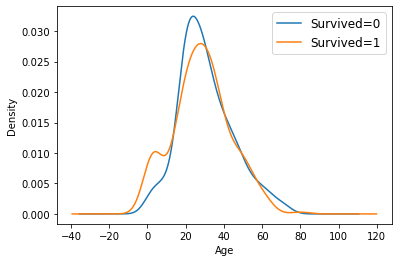

In [5]:
ax = train_raw.loc[train_raw.Survived==0, 'Age'].plot(kind='density')
ax = train_raw.loc[train_raw.Survived==1, 'Age'].plot(kind='density')
ax.legend(['Survived=0', 'Survived=1'], fontsize=12)
ax.set_xlabel('Age')
ax.set_ylabel('Density')
plt.show()

In [6]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

X_train = preprocessing(train_raw)
y_train = train_raw['Survived'].values
X_test = preprocessing(test_raw)

In [7]:
X_test.shape

(418, 15)

In [9]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20, activation='relu',))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.build(input_shape=(None,15))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                320       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [10]:
loss_fn = keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizers.Adam(learning_rate=0.05), loss=loss_fn, metrics=['AUC'])

In [11]:
type(X_train)

pandas.core.frame.DataFrame

In [12]:
model.predict(X_test).shape

(418, 1)

In [13]:
# 开始训练 5折交叉验证，把五次模型的预测结果进行平均加权
k = 5
n_epochs = 100
patience = 10


cv_aucs = []
full_val_preds = np.zeros(X_train.shape[0])
y_preds = np.zeros(X_test.shape[0])

kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=3)

for i, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
    print(f"=============Fold {i}==============")
    X_train_f, X_val_f = X_train.loc[train_index].copy(), X_train.loc[val_index].copy()
    y_train_f, y_val_f = y_train[train_index].copy(), y_train[val_index].copy()
    
    X_test_f = X_test.copy()
    
    # 待会儿试试不打乱idx的
    idx = np.arange(len(X_train_f))
    np.random.shuffle(idx)
    X_train_f = X_train_f.iloc[idx]
    y_train_f = y_train_f[idx]
    val_preds = 0
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]
    model.fit(X_train_f, y_train_f, epochs=n_epochs, batch_size=128, verbose=1,
              callbacks=callbacks, validation_data=(X_val_f, y_val_f))
    # predict
    val_preds = model.predict(X_val_f)[:,0]
    y_preds += model.predict(X_test_f)[:,0]
    
    cv_auc = roc_auc_score(y_val_f, val_preds)
    cv_aucs.append(cv_auc)
    full_val_preds[val_index] = val_preds
    
    print('\nFold %i prediction cv AUC: %.5f\n' %(i, cv_auc))

print('Mean out of fold AUC: %.5f' % np.mean(cv_aucs))
print('Full validation AUC: %.5f' % roc_auc_score(y_train, full_val_preds))    
    
    
    
    
    


=============Fold 0==============
Epoch 1/100
6/6 [==============================] - 1s 63ms/step - loss: 2.3979 - auc: 0.5687 - val_loss: 0.6712 - val_auc: 0.6943
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.7526 - auc: 0.6282 - val_loss: 0.5771 - val_auc: 0.7836
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6347 - auc: 0.7426 - val_loss: 0.5650 - val_auc: 0.7575
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6097 - auc: 0.7190 - val_loss: 0.4994 - val_auc: 0.7939
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6080 - auc: 0.8012 - val_loss: 0.5594 - val_auc: 0.8150
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5324 - auc: 0.8041 - val_loss: 0.4859 - val_auc: 0.8294
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4830 - auc: 0.8414 - val_loss: 0.4558 - val_auc: 0.8546
Epoch 8/100
6/6 [==============================] - 0s 9ms/st

6/6 [==============================] - 0s 9ms/step - loss: 0.3676 - auc: 0.8975 - val_loss: 0.4201 - val_auc: 0.8834
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3660 - auc: 0.8992 - val_loss: 0.4129 - val_auc: 0.8901
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 0.3669 - auc: 0.9014 - val_loss: 0.4207 - val_auc: 0.8906
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.3708 - auc: 0.9013 - val_loss: 0.4115 - val_auc: 0.8933
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 0.3635 - auc: 0.9025 - val_loss: 0.4169 - val_auc: 0.8932
Epoch 9/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3664 - auc: 0.9041 - val_loss: 0.4497 - val_auc: 0.8641
Epoch 10/100
6/6 [==============================] - 0s 8ms/step - loss: 0.3674 - auc: 0.9001 - val_loss: 0.4321 - val_auc: 0.8821
Epoch 11/100
6/6 [==============================] - 0s 9ms/step - loss: 0.3585 - auc: 0.9062 - val_loss

In [20]:
preds = y_preds / 5
preds = np.round(preds).astype(bool)
df = {'PassengerId': test_raw.PassengerId, 'Transported': preds}
df_preds = pd.DataFrame(df).set_index(['PassengerId'])
df_preds.to_csv('tensorflow_predction.csv')